In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cellbayesassay as cba
import pickle
from scipy.stats import dunnett, spearmanr
import re
import attila_utils

In [2]:
data_CO28151 = cba.get_data('../../resources/cell-based-assays/raw-data-cleaned-by-tina-CO28151-draft1.xlsx', 'Data')
data_CO28151

,Study,Experiment,Assay,Batch,Plate,TI,Name,conc,concentration,conc_log10,Activity
0,CO28151,Aβ release (H4 cells),Aβ38,1,1,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,4010.00000
1,CO28151,Aβ release (H4 cells),Aβ38,1,1,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,6280.00000
2,CO28151,Aβ release (H4 cells),Aβ38,1,1,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,27790.00000
3,CO28151,Aβ release (H4 cells),Aβ38,1,1,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,32560.00000
4,CO28151,Aβ release (H4 cells),Aβ38,1,1,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,20670.00000
...,...,...,...,...,...,...,...,...,...,...,...
1633,CO28151,Aβ clearance (BV2 cells),Aβ42 SN,2,2,VC,,NaN,1.000000e-09,-9.0,53839.31290
1634,CO28151,Aβ clearance (BV2 cells),Aβ42 SN,2,2,VC,,NaN,1.000000e-09,-9.0,58911.37592
1635,CO28151,Aβ clearance (BV2 cells),Aβ42 SN,2,2,VC,,NaN,1.000000e-09,-9.0,50964.09701
1636,CO28151,Aβ clearance (BV2 cells),Aβ42 SN,2,2,VC,,NaN,1.000000e-09,-9.0,NaN


In [3]:
my_treatments = ['TI21', 'TI22', 'TI26']
treatment2drugname = dict(zip(my_treatments, ['TUDCA', 'Cysteamine', 'Arundine']))
#treatment2drugname = dict(zip(my_treatments, ['Chenodiol', 'Cysteamine', 'Arundine']))

concentrations = {
    ('TI21', 1): 100e-6,
    ('TI21', 2): 10e-6,
    ('TI21', 3): 1e-6,
    ('TI22', 1): 10e-6,
    ('TI22', 2): 3e-6,
    ('TI22', 3): 1e-6,
    ('TI26', 1): 10e-6,
    ('TI26', 2): 3e-6,
    ('TI26', 3): 1e-6,
}



def get_concentration(TI, conc, concentrations=concentrations):
    TI = TI.strip()
    if re.match('^TI.*', TI):
        val = concentrations[(TI, conc)]
    else:
        val = concentrations[TI]
    return(val)


def read_data(sheet_name, assays, mean_sem_col='Group', skiprows=0):
    data = pd.read_excel(fpath, sheet_name=sheet_name, skiprows=skiprows)
    data = data.loc[~ data[mean_sem_col].isin(['mean', 'SEM'])]
    data['TI'] = data.TI.apply(lambda s: re.sub('TI\\s+', 'TI', s)).str.strip()
    data = data.applymap(lambda x: 0 if x == '<LOD' else x)
    data = data.applymap(lambda x: pd.NA if x == 'N/A' else x)
    data_nonassays = data.loc[:, ~ data.columns.isin(assays)]
    data_assays = pd.concat([data[a].astype(np.float64).to_frame(a) for a in assays], axis=1)
    data = pd.concat([data_nonassays, data_assays], axis=1)
    return(data)

def add_concentrations(data, concentrations):
    data['concentration'] = data.apply(lambda r: get_concentration(r.loc['TI'], r.loc['conc'], concentrations=concentrations), axis=1)
    data['conc_log10'] = data.concentration.apply(np.log10)
    return(data)



In [4]:
fpath = '../../resources/cell-based-assays/ideal-effects.csv'
idealfx = pd.read_csv(fpath, index_col=['experiment', 'assay'], usecols=['experiment', 'assay', 'experiment (nice)', 'assay (nice)'])
fpath = '../../resources/cell-based-assays/TI21_22_26_rawdata_sum-edited.xlsx'
datad = {}
assaysd = {}
inputd = {
    'LPS': ('LPS', 'Group', ['IFN-γ', 'IL-10', 'IL-12p70', 'IL-1β', 'IL-2', 'IL-4', 'IL-5', 'IL-6', 'KC/GRO', 'TNF-α']),
    'Abeta Toxicity': ('LC', 'IRN', ['Viability [% VC]']),
    'Abeta release': ('VC', 'Group', ['Aβ38', 'Aβ40', 'Aβ42']),
    'Abeta clearance': ('Aß', 'Group', ['Aβ42 SN', 'Aβ42 Ly']),
    'GF withdrawal': ('VC', 'IRN', ['PI', 'YOPRO', 'MTT', 'LDH']),
    'Tau phosphorylation': ('VC', 'Group', ['Tau [pg/µg prot]', 'pTau (T231)', 'ratio']),
    'NOG': ('VC', 'IRN', ['total neurite length', 'Number of branch points', 'Neurogenesis', 'average neurite length']),
}

for sheet_name, v in inputd.items():
    control, mean_sem_col, assaysl = v
    concentrationsd = concentrations.copy()
    concentrationsd.update({control: 1e-9})
    assaysd.update({sheet_name: assaysl})
    skiprows = 0
    if sheet_name in ['Abeta release', 'Abeta clearance']:
        skiprows = 1
    data = read_data(sheet_name=sheet_name, assays=assaysl, mean_sem_col=mean_sem_col, skiprows=skiprows)
    if sheet_name == 'Abeta release':
        data['TI'] = data.TI.apply(lambda s: re.sub('^VC.*', 'VC', s))
    if sheet_name == 'Abeta clearance':
        data['conc'] = data.conc.str.replace('c', '').astype(np.float64)
    data = add_concentrations(data, concentrations=concentrationsd)
    s = idealfx.xs(sheet_name, 0, 0).loc[assaysl, 'assay (nice)']
    data = data.rename(s.to_dict(), axis=1)
    mycols = data.drop(s.to_list(), axis=1).columns.to_list()
    data['idx'] = data.index
    data['Study'] = 'CO25360'
    data['Experiment'] = idealfx.xs(sheet_name)['experiment (nice)'].iloc[0]
    data = pd.melt(data, id_vars=['idx', 'Study', 'Experiment'] + mycols, value_vars=s.to_list(), var_name='Assay', value_name='Activity')
    data = data.rename({'plate': 'Plate', 'Cohort': 'Batch'}, axis=1)
    datad[sheet_name] = data

data_CO25360 = pd.concat(datad.values()).drop(['idx', 'IRN', 'ID'], axis=1)
data = pd.concat([data_CO28151, data_CO25360], axis=0)
data

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3208215962.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: 0 if x == '<LOD' else x)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3208215962.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: pd.NA if x == 'N/A' else x)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3208215962.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: 0 if x == '<LOD' else x)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3208215962.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: pd.NA if x == 'N/A' else x)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3208215962.py:32: FutureWarning: Data

,Study,Experiment,Assay,Batch,Plate,TI,Name,conc,concentration,conc_log10,Activity,Group
0,CO28151,Aβ release (H4 cells),Aβ38,1.0,1.0,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,4010.0,NaN
1,CO28151,Aβ release (H4 cells),Aβ38,1.0,1.0,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,6280.0,NaN
2,CO28151,Aβ release (H4 cells),Aβ38,1.0,1.0,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,27790.0,NaN
3,CO28151,Aβ release (H4 cells),Aβ38,1.0,1.0,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,32560.0,NaN
4,CO28151,Aβ release (H4 cells),Aβ38,1.0,1.0,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,20670.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
259,CO25360,Neurite outgrowth (primary neurons),longest neurite,NaN,NaN,VC,NaN,NaN,1.000000e-09,-9.0,37.8,NaN
260,CO25360,Neurite outgrowth (primary neurons),longest neurite,NaN,NaN,VC,NaN,NaN,1.000000e-09,-9.0,35.0,NaN
261,CO25360,Neurite outgrowth (primary neurons),longest neurite,NaN,NaN,VC,NaN,NaN,1.000000e-09,-9.0,32.7,NaN
262,CO25360,Neurite outgrowth (primary neurons),longest neurite,NaN,NaN,VC,NaN,NaN,1.000000e-09,-9.0,33.4,NaN


In [5]:
def dunnett_aggregation(res, H1_increase=False):
    score = max(-4, np.log10(res.pvalue.min()))
    score = score if score < np.log10(0.05) else 0
    stat = res.statistic[res.pvalue.argmin()]
    is_protective = stat > 0 if H1_increase == True else stat < 0
    score = - score if is_protective else score
    return(score)

fpath = '../../resources/cell-based-assays/ideal-effects.csv'
H1_increase_df = pd.read_csv(fpath, index_col=['experiment (nice)', 'assay (nice)'], usecols=['experiment (nice)', 'assay (nice)', 'H1_increase'])

def my_dunnett(study, experiment, assay, TI, data=data, batch_corr=True, control_conc_log10=-9, return_summary=False, aggregate=True, H1_increase_df=H1_increase_df):
    df = cba.extract_regr_data(study, experiment, assay, TI, data, return_data_reshaped=True, batch_corr=batch_corr)
    if df is None:
        return(None)
    gb = df.groupby('conc_log10')
    summary = pd.concat([gb['Activity'].mean().to_frame('mean'),
                         gb['Activity'].sem().to_frame('sem')], axis=1)
    if return_summary:
        return(summary)
    d = gb.groups
    control = gb.get_group(control_conc_log10)['Activity']
    d.pop(control_conc_log10)
    treatment_conc_log10 = np.sort(list(d.keys()))
    samples = [gb.get_group(k).Activity for k in treatment_conc_log10]
    res = dunnett(*samples, control=control)
    if aggregate:
        H1_increase = H1_increase_df.loc[(experiment, assay), 'H1_increase']
        val = dunnett_aggregation(res, H1_increase)
        return(val)
    return(res)

study = 'CO25360'
experiment = 'Aβ clearance (BV2 cells)'
assay = 'Aβ42 Ly'
TI = 'TI21'

df = cba.extract_regr_data(study, experiment, assay, TI, data, return_data_reshaped=True)
print(my_dunnett(study, experiment, assay, TI, aggregate=False))
print(my_dunnett(study, experiment, assay, TI, aggregate=True))
my_dunnett(study, experiment, assay, TI, return_summary=True)

Dunnett's test (95.0% Confidence Interval)
Comparison               Statistic  p-value  Lower CI  Upper CI
 (Sample 0 - Control)     -0.734     0.835-31878.995 17420.218
 (Sample 1 - Control)     -0.522     0.931-29792.162 19507.051
 (Sample 2 - Control)      1.163     0.562-13196.662 36102.551

0


,mean,sem
conc_log10,,
-9.0,19661.222222,6264.053276
-6.0,12431.833333,3396.638489
-5.0,14518.666667,1976.763106
-4.0,31114.166667,7064.013781


In [6]:
P_CO25360 = pd.read_csv('../../results/2023-09-26-cell-bayes-assays/H102_posteriors.csv', index_col=[0, 1], header=[0, 1])
P_CO25360 = P_CO25360.rename({'TUDCA': 'TI21', 'Cysteamine': 'TI22', 'Arundine': 'TI26'}, axis=1, level=0)
P_CO25360['study'] = 'CO25360'
P_CO25360 = P_CO25360.set_index('study', append=True)
P_CO25360 = P_CO25360.swaplevel(1,2).swaplevel(0, 1).stack(level=0)
P_CO25360

H1  \
study                                                                       
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI21  0.99275   
                                                            TI22  0.00000   
                                                            TI26  0.87900   
                                                    Aβ42 SN TI21  0.09825   
                                                            TI22  0.00200   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.00075   
                                                            TI26  0.05100   
                                                    YOPRO   TI21  0.00875   
                                                            TI22  0.00000   
                                                            TI26  0.00050   

                                                                       H0  \
study                                                                       
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI21  0.00725   
                                                            TI22  0.00000   
                                                            TI26  0.12000   
                                                    Aβ42 SN TI21  0.86375   
                                                            TI22  0.18175   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.98275   
                                                            TI26  0.94900   
                                                    YOPRO   TI21  0.97275   
                                                            TI22  0.95175   
                                                            TI26  0.97700   

                                                                       H2  
study                                                                      
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI21  0.00000  
                                                            TI22  1.00000  
                                                            TI26  0.00100  
                                                    Aβ42 SN TI21  0.03800  
                                                            TI22  0.81625  
...                                                                   ...  
        Trophic factor withdrawal (primary neurons) PI      TI22  0.01650  
                                                            TI26  0.00000  
                                                    YOPRO   TI21  0.01850  
                                                            TI22  0.04825  
                                                            TI26  0.02250  

[91 rows x 3 columns]

In [7]:
P_CO28151 = pd.read_csv('../../results/2024-02-14-cell-bayes/H102_posteriors.csv', index_col=[0, 1, 2, 3]).drop('name', axis=1)
P_CO28151

H1       H0       H2
study   experiment               assay   TI                             
CO28151 Aβ clearance (BV2 cells) Aβ42 Ly TI1   0.07300  0.77600  0.15100
                                         TI2   0.99925  0.00075  0.00000
                                         TI3   0.25525  0.69925  0.04550
                                         TI4   0.61225  0.38000  0.00775
                                         TI5   0.99875  0.00125  0.00000
...                                                ...      ...      ...
        Aβ release (H4 cells)    Aβ42    TI11  0.00000  0.37325  0.62675
                                         TI12  0.00000  0.00200  0.99800
                                         TI13  0.02650  0.95625  0.01725
                                         TI14  0.00025  0.95300  0.04675
                                         TI15  0.06325  0.93675  0.00000

[75 rows x 3 columns]

In [8]:
P = pd.concat([P_CO28151, P_CO25360], axis=0)
P

H1  \
study                                                                       
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.07300   
                                                            TI2   0.99925   
                                                            TI3   0.25525   
                                                            TI4   0.61225   
                                                            TI5   0.99875   
...                                                                   ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.00075   
                                                            TI26  0.05100   
                                                    YOPRO   TI21  0.00875   
                                                            TI22  0.00000   
                                                            TI26  0.00050   

                                                                       H0  \
study                                                                       
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.77600   
                                                            TI2   0.00075   
                                                            TI3   0.69925   
                                                            TI4   0.38000   
                                                            TI5   0.00125   
...                                                                   ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.98275   
                                                            TI26  0.94900   
                                                    YOPRO   TI21  0.97275   
                                                            TI22  0.95175   
                                                            TI26  0.97700   

                                                                       H2  
study                                                                      
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.15100  
                                                            TI2   0.00000  
                                                            TI3   0.04550  
                                                            TI4   0.00775  
                                                            TI5   0.00000  
...                                                                   ...  
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.01650  
                                                            TI26  0.00000  
                                                    YOPRO   TI21  0.01850  
                                                            TI22  0.04825  
                                                            TI26  0.02250  

[166 rows x 3 columns]

In [9]:
def main_dunnett(study, experiment, assay, TI, data=data, aggregate=True, batch_corr=True):
    try:
        val = my_dunnett(study, experiment, assay, TI, data=data, aggregate=aggregate, batch_corr=batch_corr)
    except Exception:
    #except (KeyError, AttributeError, error):
        val = None
    return(val)

l = [main_dunnett(*x, aggregate=True) for x in P.index]
Dunnett_s = pd.Series(l, index=P.index)
Dunnett_s

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3675982619.py:2: RuntimeWarning: divide by zero encountered in log10
  score = max(-4, np.log10(res.pvalue.min()))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3675982619.py:2: RuntimeWarning: divide by zero encountered in log10
  score = max(-4, np.log10(res.pvalue.min()))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3675982619.py:2: RuntimeWarning: divide by zero encountered in log10
  score = max(-4, np.log10(res.pvalue.min()))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3675982619.py:2: RuntimeWarning: divide by zero encountered in log10
  score = max(-4, np.log10(res.pvalue.min()))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3675982619.py:2: RuntimeWarning: divide by zero encountered in log10
  score = max(-4, np.log10(res.pvalue.min()))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_84245/3675982619.py:2: RuntimeWarning: di

treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches


study                                                              
CO28151  Aβ clearance (BV2 cells)                     Aβ42 Ly  TI1     0.000000
                                                               TI2     4.000000
                                                               TI3     0.000000
                                                               TI4     0.000000
                                                               TI5     1.783760
                                                                         ...   
CO25360  Trophic factor withdrawal (primary neurons)  PI       TI22    0.000000
                                                               TI26    3.186717
                                                      YOPRO    TI21   -1.504630
                                                               TI22   -2.053574
                                                               TI26    0.000000
Length: 166, dtype: float64

In [10]:
l = [main_dunnett(*x, aggregate=True, batch_corr=False) for x in P.index]
Dunnett_s_nocorr = pd.Series(l, index=P.index)
Dunnett_s_nocorr

treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches


study                                                              
CO28151  Aβ clearance (BV2 cells)                     Aβ42 Ly  TI1     0.000000
                                                               TI2     0.000000
                                                               TI3     0.000000
                                                               TI4     0.000000
                                                               TI5     0.000000
                                                                         ...   
CO25360  Trophic factor withdrawal (primary neurons)  PI       TI22    0.000000
                                                               TI26    3.179769
                                                      YOPRO    TI21   -1.505196
                                                               TI22   -2.054267
                                                               TI26    0.000000
Length: 166, dtype: float64

In [11]:
results = pd.concat([P, Dunnett_s.to_frame('Dunnett score'), Dunnett_s_nocorr.to_frame('Dunnett score -batch')], axis=1)
results

H1  \
study                                                                       
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.07300   
                                                            TI2   0.99925   
                                                            TI3   0.25525   
                                                            TI4   0.61225   
                                                            TI5   0.99875   
...                                                                   ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.00075   
                                                            TI26  0.05100   
                                                    YOPRO   TI21  0.00875   
                                                            TI22  0.00000   
                                                            TI26  0.00050   

                                                                       H0  \
study                                                                       
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.77600   
                                                            TI2   0.00075   
                                                            TI3   0.69925   
                                                            TI4   0.38000   
                                                            TI5   0.00125   
...                                                                   ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.98275   
                                                            TI26  0.94900   
                                                    YOPRO   TI21  0.97275   
                                                            TI22  0.95175   
                                                            TI26  0.97700   

                                                                       H2  \
study                                                                       
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.15100   
                                                            TI2   0.00000   
                                                            TI3   0.04550   
                                                            TI4   0.00775   
                                                            TI5   0.00000   
...                                                                   ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.01650   
                                                            TI26  0.00000   
                                                    YOPRO   TI21  0.01850   
                                                            TI22  0.04825   
                                                            TI26  0.02250   

                                                                  Dunnett score  \
study                                                                             
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1        0.000000   
                                                            TI2        4.000000   
                                                            TI3        0.000000   
                                                            TI4        0.000000   
                                                            TI5        1.783760   
...                                                                         ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22       0.000000   
                                                            TI26       3.186717   
                                                    YOPRO   TI21      -1.504630   
                                                            TI22      -2.053574   
                                                            TI26     

['named-figure/posterior-vs-dunnettscore-spearman.png',
 'named-figure/posterior-vs-dunnettscore-spearman.pdf']

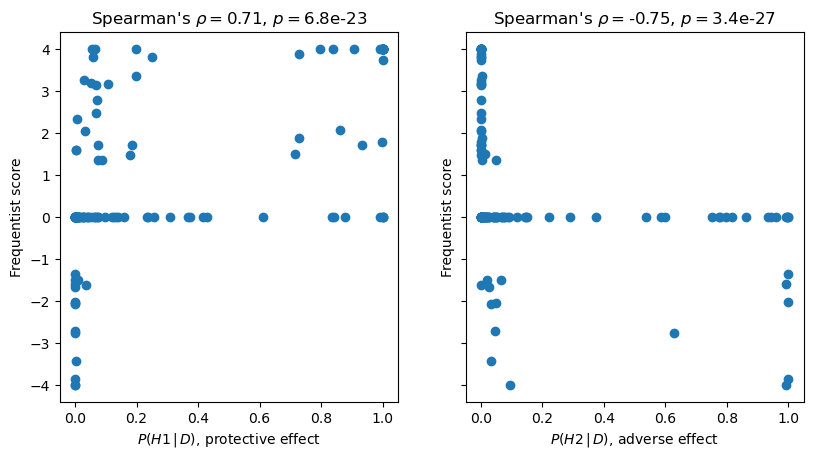

In [12]:
def my_scatter(results=results, y='Dunnett score', bayes_cols=['H1', 'H2']):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9.6, 4.8))
    for axi, H, effect in zip(ax, bayes_cols, ['protective', 'adverse']):
        axi.scatter(x=H, y=y, data=results)
        axi.set_xlabel(r'$P({} \, | \, D)$, {} effect'.format(H, effect))
        axi.set_ylabel('Frequentist score')
        v = spearmanr(results[[H, y]].dropna())
        axi.set_title(r"Spearman's $\rho=${:1.2}, $p=${:1.2}".format(v.statistic, v.pvalue))
    return((fig, ax))

fig, ax = my_scatter(results=results, y='Dunnett score', bayes_cols=['H1', 'H2'])
attila_utils.savefig(fig, 'posterior-vs-dunnettscore-spearman')

['named-figure/posterior-vs-dunnettscore-spearman-no-batch-corr.png',
 'named-figure/posterior-vs-dunnettscore-spearman-no-batch-corr.pdf']

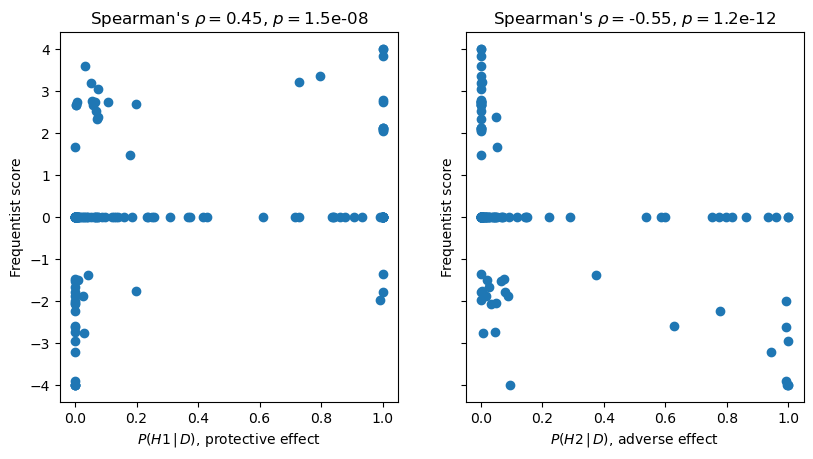

In [13]:
fig, ax = my_scatter(results=results, y='Dunnett score -batch', bayes_cols=['H1', 'H2'])
attila_utils.savefig(fig, 'posterior-vs-dunnettscore-spearman-no-batch-corr')

In [14]:
P_TI = P.unstack(level=-1).groupby(level=1).mean().mean().unstack(level=0)
P_TI

,H1,H0,H2
TI1,0.249875,0.545708,0.204417
TI2,0.697542,0.136000,0.166458
TI3,0.813813,0.174813,0.011375
TI4,0.903062,0.095000,0.001937
TI5,0.999688,0.000312,0.000000
TI6,0.435479,0.390458,0.174063
TI7,0.983313,0.016687,0.000000
TI8,0.265583,0.519104,0.215312
TI9,0.960688,0.038500,0.000812
TI10,0.073437,0.693125,0.233437


In [15]:
BF_TI = pd.concat([2 * np.log((P_TI[H] / P_TI['H0'])).to_frame(col) for H, col in zip(['H1', 'H2'], ['BF1', 'BF2'])], axis=1)
def reshape_dunnett(s=Dunnett_s, col='Dunnett score'):
    val = s.unstack(level=-1).groupby(level=1).mean().mean().to_frame(col)
    return(val)
results_agg = pd.concat([BF_TI, reshape_dunnett(s=Dunnett_s, col='Dunnett score'), reshape_dunnett(s=Dunnett_s_nocorr, col='Dunnett score -batch')], axis=1)
results_agg = results_agg.sort_values('BF1', ascending=False)
results_agg['Bayes rank'] = np.arange(len(results_agg)) + 1
results_agg = results_agg.sort_values('Dunnett score', ascending=False)
results_agg['Dunnett rank'] = np.arange(len(results_agg)) + 1
results_agg = results_agg.sort_values('Dunnett score -batch', ascending=False)
results_agg['Dunnett rank -batch'] = np.arange(len(results_agg)) + 1
results_agg

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,BF1,BF2,Dunnett score,Dunnett score -batch,Bayes rank,Dunnett rank,Dunnett rank -batch
TI8,-1.340352,-1.760028,2.534546,1.504135,8,6,1
TI7,8.152534,-inf,3.427243,1.371012,2,2,2
TI5,16.141187,-inf,3.445940,1.365430,1,1,3
TI15,-4.025503,-6.737465,1.597163,1.360056,14,9,4
TI10,-4.489551,-2.176592,2.241181,1.345424,15,8,5
TI3,3.076032,-5.464592,3.000000,1.335420,6,5,6
TI9,6.433982,-7.716595,2.333333,0.920140,3,7,7
TI26,-2.236818,-4.075074,0.425839,0.433381,12,12,8
TI21,-1.592921,-3.669913,0.697015,0.205278,10,11,9
TI4,4.503830,-7.784957,3.000000,-0.115508,4,4,10


['named-figure/BF-vs-dunnettscore-spearman.png',
 'named-figure/BF-vs-dunnettscore-spearman.pdf']

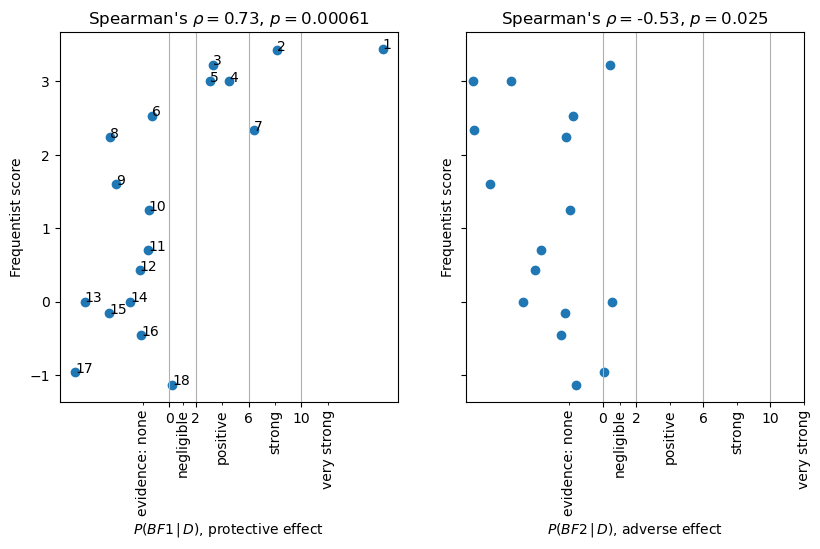

In [16]:
def my_scatter_BF(results=results_agg, y='Dunnett score', rank_col='Dunnett rank', bayes_cols=['BF1', 'BF2']):
    fig, ax = my_scatter(results=results, y=y, bayes_cols=bayes_cols)
    for axi in ax:
        xticks_major = [0, 2, 6, 10]
        xticks_minor = [-2, 1, 4, 8, 12]
        axi.set_xticks(xticks_major, minor=False)
        axi.set_xticks(xticks_minor, minor=True)
        xticklabels_minor = ['evidence: none', 'negligible', 'positive', 'strong', 'very strong']
        axi.set_xticklabels(xticklabels_minor, minor=True, rotation=90)
        axi.grid(axis='x')
    axi = ax[0]
    for i in range(len(results)):
        row = results.iloc[i]
        axi.text(x=row.loc['BF1'], y=row.loc[y], s=str(np.int64(row.loc[rank_col])))
    return((fig, ax))

fig, ax = my_scatter_BF(results=results_agg, y='Dunnett score', bayes_cols=['BF1', 'BF2'])
attila_utils.savefig(fig, 'BF-vs-dunnettscore-spearman')

['named-figure/BF-vs-dunnettscore-spearman-no-batch-corr.png',
 'named-figure/BF-vs-dunnettscore-spearman-no-batch-corr.pdf']

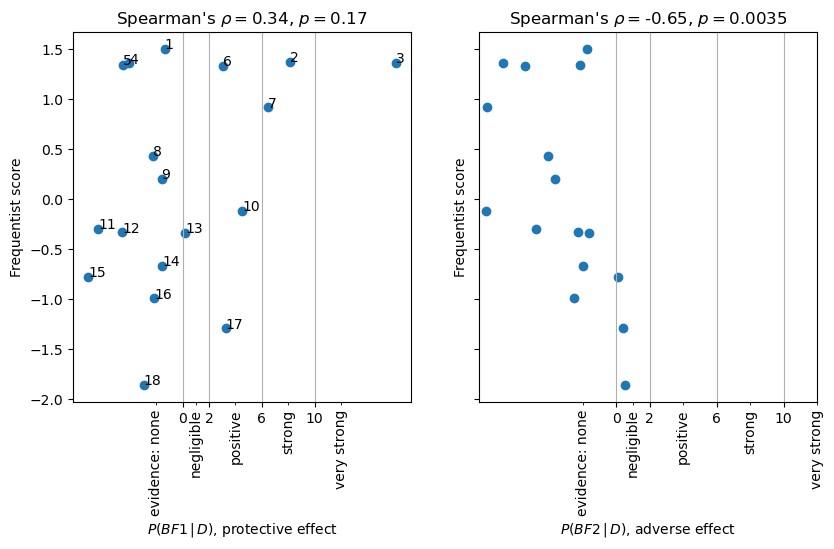

In [17]:
fig, ax = my_scatter_BF(results=results_agg, y='Dunnett score -batch', rank_col='Dunnett rank -batch', bayes_cols=['BF1', 'BF2'])
attila_utils.savefig(fig, 'BF-vs-dunnettscore-spearman-no-batch-corr')

In [18]:
%connect_info

{
  "shell_port": 54259,
  "iopub_port": 54260,
  "stdin_port": 54261,
  "control_port": 54263,
  "hb_port": 54262,
  "ip": "127.0.0.1",
  "key": "327b58e3-c6aa0d82d4c6a38d594cf962",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-03-04-cell-bayes-vs-frequentist/2024-03-04-cell-bayes-vs-frequentist.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-4e353a2a-1294-4a2b-a833-0b012e3b74e1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
